In [1]:
import tensorflow as tf
import torch

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

from kan import *
import time

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import csv

from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuda


In [3]:
# read dataset
df = pd.read_csv("Dataset/bank_marketing/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";")

In [4]:
# preprocessing steps for numerical and categorical data (replace y, replace missing value, encode, scale)
# replace 'yes' with 1 and 'no' with 0
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

target = df['y']
df = df.drop(columns=['y'])

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

features = preprocessor.fit_transform(df)

C:\Users\PC\AppData\Local\Temp\ipykernel_18000\1479273297.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=30)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=30)

train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test, dtype=torch.float32).to(device)
val_input = torch.tensor(X_val, dtype=torch.float32).to(device)

train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

dataset = {
    'train_input' : train_input,
    'test_input'  : test_input,
    'train_label' : train_label,
    'test_label'  : test_label,
    'val_input'   : val_input,
    'val_label'   : val_label
}

In [6]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

In [7]:
torch.cuda.empty_cache()

In [8]:
st = time.time()

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], device=device).to(device)
final_result = model.train(dataset, metrics=(train_acc, test_acc), device=device)

et = time.time()
duration_b4 = et-st

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", duration_b4)

train loss: 2.33e-01 | test loss: 2.40e-01 | reg: 6.52e+01 : 100%|█| 100/100 [11:11<00:00,  6.71s/it

Accuracy 0.9224263429641724 0.915027916431427
Duration 671.1083166599274


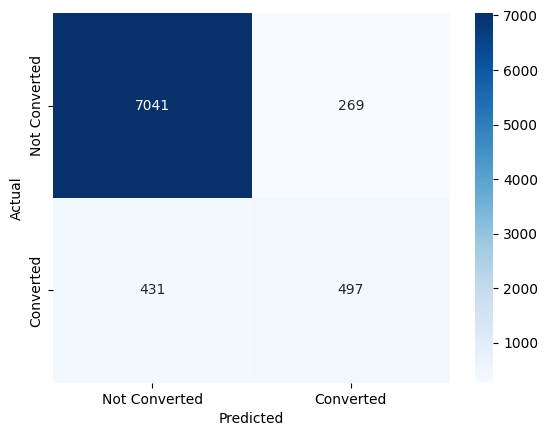

Accuracy: 0.9150279193979121
Precision: 0.6488250652741514
Recall: 0.5355603448275862
F1 Score: 0.586776859504132


In [9]:
# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy_b4 = (tn+tp)/(tn+fp+fn+tp)
precision_b4 = tp / (tp + fp) if (tp + fp) != 0 else 0
recall_b4 = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score_b4 = 2 * (precision_b4 * recall_b4) / (precision_b4 + recall_b4) if (precision_b4 + recall_b4) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy_b4}')
print(f'Precision: {precision_b4}')
print(f'Recall: {recall_b4}')
print(f'F1 Score: {f1_score_b4}')

In [10]:
# fine-tune grid
st = time.time()

grid_values = [1, 3, 5, 7]
results = []

for grid_val in grid_values:
    print(f"\nTraining with grid = {grid_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=grid_val, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with grid = 1


train loss: 2.43e-01 | test loss: 2.48e-01 | reg: 1.05e+02 : 100%|█| 100/100 [10:27<00:00,  6.27s/it


Train Accuracy: 0.91324049, Test Accuracy: 0.90774459, Duration: 627.02 sec

Training with grid = 3


train loss: 2.34e-01 | test loss: 2.41e-01 | reg: 4.44e+01 : 100%|█| 100/100 [11:03<00:00,  6.64s/it


Train Accuracy: 0.92092907, Test Accuracy: 0.91369265, Duration: 663.73 sec

Training with grid = 5


train loss: 2.31e-01 | test loss: 2.42e-01 | reg: 4.42e+01 : 100%|█| 100/100 [11:12<00:00,  6.73s/it


Train Accuracy: 0.92311424, Test Accuracy: 0.91332847, Duration: 672.91 sec

Training with grid = 7


train loss: 2.30e-01 | test loss: 2.43e-01 | reg: 4.79e+01 : 100%|█| 100/100 [11:46<00:00,  7.07s/it

Train Accuracy: 0.92501616, Test Accuracy: 0.91138625, Duration: 706.60 sec


In [11]:
# fine-tune k
st = time.time()

k_values = [1, 3, 5, 7]
results = []

for k_val in k_values:
    print(f"\nTraining with k = {k_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=k_val, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with k = 1


train loss: 2.33e-01 | test loss: 2.41e-01 | reg: 9.43e+01 : 100%|█| 100/100 [11:03<00:00,  6.64s/it


Train Accuracy: 0.92194074, Test Accuracy: 0.91442096, Duration: 663.92 sec

Training with k = 3


train loss: 2.32e-01 | test loss: 2.42e-01 | reg: 6.82e+01 : 100%|█| 100/100 [11:06<00:00,  6.66s/it


Train Accuracy: 0.92210263, Test Accuracy: 0.91223598, Duration: 666.23 sec

Training with k = 5


train loss: 2.38e-01 | test loss: 2.44e-01 | reg: 7.48e+01 : 100%|█| 100/100 [12:13<00:00,  7.33s/it


Train Accuracy: 0.91825831, Test Accuracy: 0.91138625, Duration: 733.50 sec

Training with k = 7


train loss: 2.35e-01 | test loss: 2.43e-01 | reg: 6.43e+01 : 100%|█| 100/100 [12:48<00:00,  7.69s/it

Train Accuracy: 0.92076725, Test Accuracy: 0.91393542, Duration: 768.83 sec


In [12]:
# fine-tune step
st = time.time()

step_values = [25, 50, 75, 100]
results = []

for step_val in step_values:
    print(f"\nTraining with step = {step_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=1, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=step_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with step = 25


train loss: 2.37e-01 | test loss: 2.43e-01 | reg: 5.98e+01 : 100%|██| 25/25 [02:43<00:00,  6.55s/it]


Train Accuracy: 0.91817737, Test Accuracy: 0.91199321, Duration: 163.87 sec

Training with step = 50


train loss: 2.33e-01 | test loss: 2.41e-01 | reg: 5.85e+01 : 100%|██| 50/50 [05:19<00:00,  6.39s/it]


Train Accuracy: 0.92234540, Test Accuracy: 0.91454238, Duration: 319.66 sec

Training with step = 75


train loss: 2.34e-01 | test loss: 2.42e-01 | reg: 7.74e+01 : 100%|██| 75/75 [08:06<00:00,  6.49s/it]


Train Accuracy: 0.91935092, Test Accuracy: 0.91284293, Duration: 486.90 sec

Training with step = 100


train loss: 2.33e-01 | test loss: 2.42e-01 | reg: 8.25e+01 : 100%|█| 100/100 [10:32<00:00,  6.32s/it

Train Accuracy: 0.92169797, Test Accuracy: 0.91102207, Duration: 632.10 sec


In [13]:
# fine-tune lamb
st = time.time()

lamb_values = [0, 0.1, 0.01, 0.001]
results = []

for lamb_val in lamb_values:
    print(f"\nTraining with lamb = {lamb_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=1, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=50, lamb=lamb_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with lamb = 0


train loss: 2.34e-01 | test loss: 2.41e-01 | reg: 5.17e+01 : 100%|██| 50/50 [05:24<00:00,  6.48s/it]


Train Accuracy: 0.92157656, Test Accuracy: 0.91369265, Duration: 324.07 sec

Training with lamb = 0.1


train loss: 3.17e-01 | test loss: 3.20e-01 | reg: 1.25e+01 : 100%|██| 50/50 [05:20<00:00,  6.41s/it]


Train Accuracy: 0.88920361, Test Accuracy: 0.88783687, Duration: 320.63 sec

Training with lamb = 0.01


train loss: 2.63e-01 | test loss: 2.63e-01 | reg: 1.20e+01 : 100%|██| 50/50 [05:28<00:00,  6.57s/it]


Train Accuracy: 0.90118158, Test Accuracy: 0.89742655, Duration: 328.42 sec

Training with lamb = 0.001


train loss: 2.51e-01 | test loss: 2.52e-01 | reg: 1.31e+01 : 100%|██| 50/50 [05:34<00:00,  6.69s/it]

Train Accuracy: 0.90935576, Test Accuracy: 0.90592378, Duration: 334.64 sec


In [14]:
# fine-tune lamb entropy
st = time.time()

lamb_ent_values = [0, 0.1, 0.01, 0.001]
results = []

for lamb_ent_val in lamb_ent_values:
    print(f"\nTraining with lamb entropy = {lamb_ent_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=1, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=50, lamb=0, lamb_entropy=lamb_ent_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with lamb entropy = 0


train loss: 2.35e-01 | test loss: 2.43e-01 | reg: 4.35e+01 : 100%|██| 50/50 [05:26<00:00,  6.53s/it]


Train Accuracy: 0.91935092, Test Accuracy: 0.91090071, Duration: 326.31 sec

Training with lamb entropy = 0.1


train loss: 2.36e-01 | test loss: 2.42e-01 | reg: 1.09e+02 : 100%|██| 50/50 [05:33<00:00,  6.68s/it]


Train Accuracy: 0.91854161, Test Accuracy: 0.91344988, Duration: 333.89 sec

Training with lamb entropy = 0.01


train loss: 2.34e-01 | test loss: 2.42e-01 | reg: 4.05e+01 : 100%|██| 50/50 [05:25<00:00,  6.51s/it]


Train Accuracy: 0.92096955, Test Accuracy: 0.91175044, Duration: 325.29 sec

Training with lamb entropy = 0.001


train loss: 2.34e-01 | test loss: 2.43e-01 | reg: 4.00e+01 : 100%|██| 50/50 [05:23<00:00,  6.47s/it]

Train Accuracy: 0.91975558, Test Accuracy: 0.91369265, Duration: 323.62 sec


train loss: 2.34e-01 | test loss: 2.41e-01 | reg: 4.15e+01 : 100%|██| 50/50 [05:26<00:00,  6.53s/it]

Accuracy 0.9217788577079773 0.9135712385177612
Duration 326.672890663147


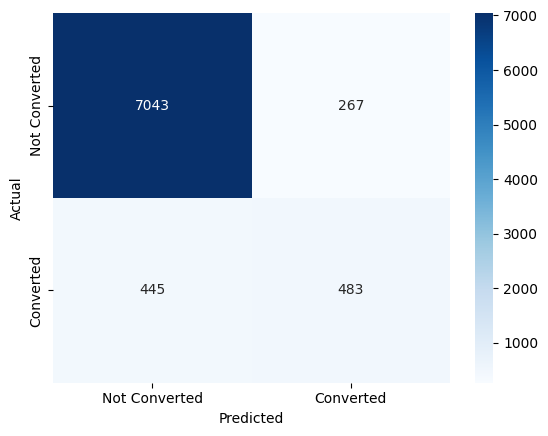

Accuracy: 0.9135712551590192
Precision: 0.644
Recall: 0.5204741379310345
F1 Score: 0.5756853396901074


In [15]:
# after fine-tune
st = time.time()

best_model = {'grid': 3, 'k': 1, 'step': 50, 'lamb': 0, 'lamb_entropy': 0.001}

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)

et = time.time()
duration = et-st

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", duration)

# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tn+tp)/(tn+fp+fn+tp)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

In [16]:
# save to csv
filename = "30.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Before", "After"])
    writer.writerow(["Accuracy", accuracy_b4, accuracy])
    writer.writerow(["Precision", precision_b4, precision])
    writer.writerow(["Recall", recall_b4, recall])
    writer.writerow(["F1 Score", f1_score_b4, f1_score])
    writer.writerow(["Duration", duration_b4, duration])